# Conformal Classification

In this notebook we derive classification confidence intervals using absolute Pearson residuals as non-conformity scores.

This is an **experimental** variant of conformal classification tailored to produce confidence intervals for predicted probabilities.

### **1. Non-Conformity Scores**
- **Pearson Residuals** are used as the measure of non-conformity:
  $$
  r_i = \frac{y_i - \hat{p}_i}{\sqrt{\hat{p}_i (1 - \hat{p}_i)}}
  $$
  - $r_i$: Residual for sample $i$.
  - $y_i$: True label $0$ or $1$.
  - $\hat{p}_i$: Predicted probability of class $1$.
  - $\sqrt{\hat{p}_i (1 - \hat{p}_i)}$: Standard deviation of the Bernoulli distribution.

  Pearson residuals measure how far the true outcome ($y_i$) deviates from the prediction ($\hat{p}_i$), scaled by the standard deviation.
  We do not use the absolute value of residuals at this step to follow the convention of the Wald test.

### **2. Quantile-Based Confidence Interval Derivation**
- The residuals ($r_i$) from the **calibration set** are used to calculate the quantile corresponding to a desired confidence level ($1-\alpha$):
  $$
  q_\alpha = \text{Quantile}_{1-\alpha}(|r_{\text{calibration}}|)
  $$
  - $q_\alpha$ defines the maximum allowable deviation (non-conformity) for the desired confidence level.

### **3. Confidence Interval Formula**
- Using the predicted probability $(\hat{P}_i)$ and the quantile ($q_\alpha$), confidence intervals are derived as:
  $$
  \text{Lower Bound (LB)} = \max\left(0, \hat{P}_i - q_\alpha \cdot \sqrt{\hat{P}_i (1 - \hat{P}_i)}\right)
  $$
  $$
  \text{Upper Bound (UB)} = \min\left(1, \hat{P}_i + q_\alpha \cdot \sqrt{\hat{P}_i (1 - \hat{P}_i)}\right)
  $$

Author: https://github.com/deburky

## Synthetic Dataset

model = Logistic Regression, diff = -0.11
model = Naive Bayes, diff = -0.59
model = SVM, diff = -0.00
model = MLP, diff = -0.00
model = Random Forest, diff = -0.22


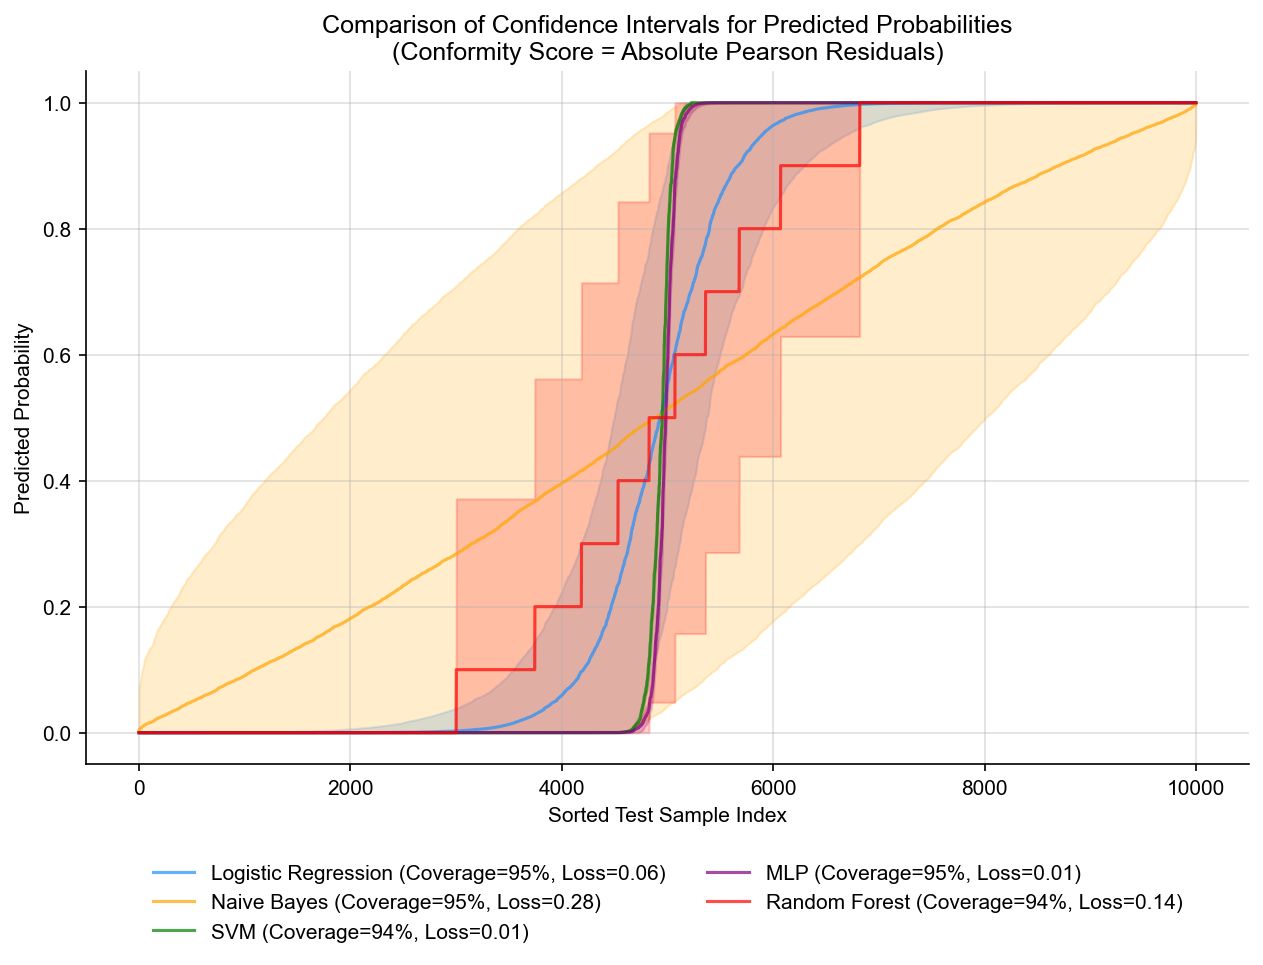

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

# Set font to Arial
plt.rcParams['font.family'] = 'Arial'

# Function to compute squared Pearson residuals
def compute_pearson_residuals(y_true, y_pred_proba):
    y_pred_proba = np.clip(y_pred_proba, 1e-10, 1 - 1e-10)
    return (y_true - y_pred_proba) / np.sqrt(y_pred_proba * (1 - y_pred_proba))

# Function to compute confidence intervals
def compute_confidence_intervals(y_pred_proba, q_alpha):
    lower_bound = []
    upper_bound = []
    for prob in y_pred_proba:
        lb = max(0, prob - np.sqrt(q_alpha * prob * (1 - prob)))
        ub = min(1, prob + np.sqrt(q_alpha * prob * (1 - prob)))
        lower_bound.append(lb)
        upper_bound.append(ub)
    return np.array(lower_bound), np.array(upper_bound)

# Function to calculate coverage
def calculate_coverage(y_true, lower_bounds, upper_bounds):
    return np.mean((y_true >= lower_bounds) & (y_true <= upper_bounds))

# Generate synthetic data
np.random.seed(42)
n_samples = 50_000
X = np.random.rand(n_samples, 5)
y = (X.sum(axis=1) > 2.5).astype(int)  # Nonlinear threshold function

# Split data into train, calibration, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_cal, X_test, y_cal, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Store interval widths
interval_widths = {}

# List of classifiers to compare
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True),
    "MLP": MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=10, random_state=42)
}

# Colors for plots
colors = ["dodgerblue", "orange", "green", "purple", "red", "cyan"]

# Dictionary to store intervals for each classifier
intervals = {}

plt.figure(figsize=(10, 6), dpi=150)

for i, (name, clf) in enumerate(classifiers.items()):
    # Train the classifier
    clf.fit(X_train, y_train)

    # Compute non-conformity scores for calibration set
    y_cal_pred_proba = clf.predict_proba(X_cal)[:, 1]
    r2_cal = compute_pearson_residuals(y_cal, y_cal_pred_proba)
    r2_cal_abs = np.abs(r2_cal)

    # Determine the (1-alpha) quantile as the cutoff
    alpha = 0.1
    q_alpha = np.quantile(r2_cal_abs, 1 - alpha)

    # Apply the method to the test set
    y_test_pred_proba = clf.predict_proba(X_test)[:, 1]
    lower_bounds, upper_bounds = compute_confidence_intervals(y_test_pred_proba, q_alpha)

    # Compute interval widths and store in the dictionary
    widths = upper_bounds - lower_bounds
    interval_widths[name] = widths

    # Sort predictions and corresponding intervals for visualization
    sorted_indices = np.argsort(y_test_pred_proba)
    y_test_pred_proba_sorted = y_test_pred_proba[sorted_indices]
    lower_bounds_sorted = lower_bounds[sorted_indices]
    upper_bounds_sorted = upper_bounds[sorted_indices]

    # Calculate coverage
    coverage = calculate_coverage(y_test, lower_bounds, upper_bounds)

    # Compute log loss
    log_loss_value = log_loss(y_test, y_test_pred_proba)
    
    print(f"model = {name}, diff = {lower_bounds_sorted.mean() - upper_bounds_sorted.mean():.2f}")

    # Store intervals for analysis
    intervals[name] = {
        "predicted_probabilities": y_test_pred_proba_sorted,
        "lower_bounds": lower_bounds_sorted,
        "upper_bounds": upper_bounds_sorted,
        "coverage": coverage
    }

    # Plot results
    plt.plot(
        y_test_pred_proba_sorted,
        label=(
            f"{name} (Coverage={coverage:.0%}, "
            f"Loss={log_loss_value:.2f})"
            # f"χ2={chi_square:.2f})"
        ),
        color=colors[i], alpha=0.7
    )
    plt.fill_between(
        range(len(y_test_pred_proba_sorted)),
        lower_bounds_sorted,
        upper_bounds_sorted,
        color=colors[i],
        alpha=0.2
    )

# plt.axhline(0.5, color="black", linestyle="--", label="Decision Boundary")
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Predicted Probability")
plt.title("Comparison of Confidence Intervals for Predicted Probabilities\n(Conformity Score = Absolute Pearson Residuals)")
# Disable spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(bbox_to_anchor=(0.5, -.2), loc='center', ncol=2, frameon=False)
plt.grid(alpha=0.4)
plt.show()

## Real-World Dataset

/Users/deburky/Library/Caches/pypoetry/virtualenvs/python-ml-projects-QQGQytla-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


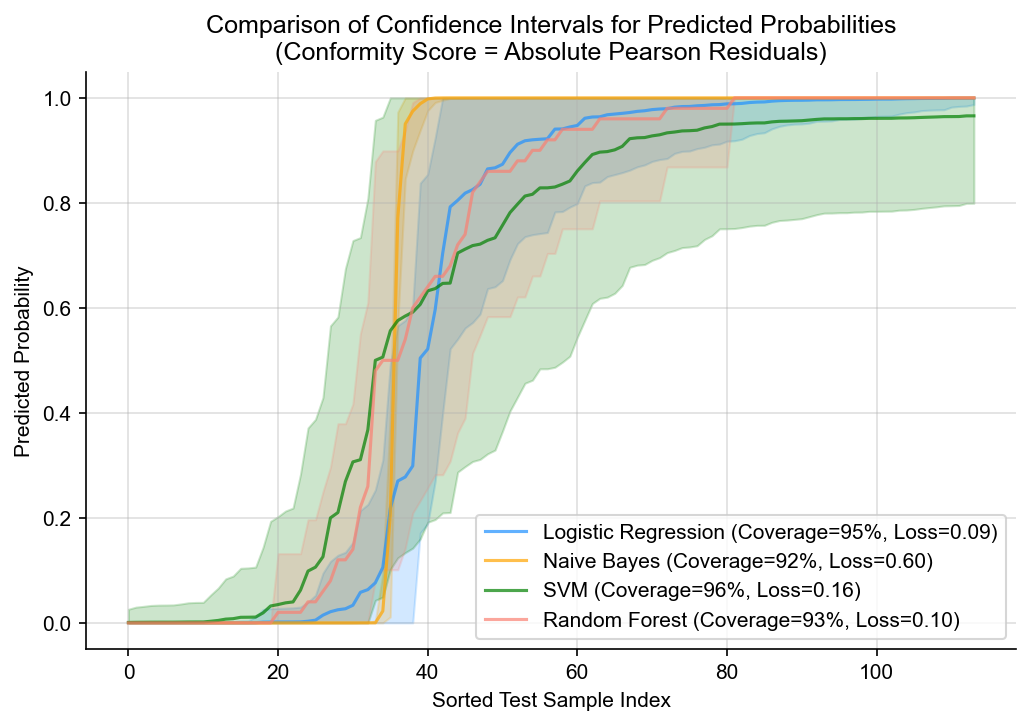

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

# Set font to Arial
plt.rcParams['font.family'] = 'Arial'

# Function to compute squared Pearson residuals
def compute_pearson_residuals(y_true, y_pred_proba):
    y_pred_proba = np.clip(y_pred_proba, 1e-10, 1 - 1e-10)
    return (y_true - y_pred_proba) / np.sqrt(y_pred_proba * (1 - y_pred_proba))

# Function to compute confidence intervals
def compute_confidence_intervals(y_pred_proba, q_alpha):
    lower_bound = []
    upper_bound = []
    for prob in y_pred_proba:
        lb = max(0, prob - np.sqrt(q_alpha * prob * (1 - prob)))
        ub = min(1, prob + np.sqrt(q_alpha * prob * (1 - prob)))
        lower_bound.append(lb)
        upper_bound.append(ub)
    return np.array(lower_bound), np.array(upper_bound)

# Function to calculate coverage
def calculate_coverage(y_true, lower_bounds, upper_bounds):
    return np.mean((y_true >= lower_bounds) & (y_true <= upper_bounds))

# Load the Breast Cancer Dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Split data into train, calibration, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_cal, X_test, y_cal, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Store interval widths
interval_widths = {}

# List of classifiers to compare
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True),
    # "MLP": MLPClassifier(hidden_layer_sizes=(5, 3), max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42)
}

# Colors for plots
colors = ["dodgerblue", "orange", "green", "salmon", "turquoise"]

# Dictionary to store intervals for each classifier
intervals = {}

plt.figure(figsize=(8, 5), dpi=150)

for i, (name, clf) in enumerate(classifiers.items()):
    # Train the classifier
    clf.fit(X_train, y_train)

    # Compute non-conformity scores for calibration set
    y_cal_pred_proba = clf.predict_proba(X_cal)[:, 1]
    r2_cal = compute_pearson_residuals(y_cal, y_cal_pred_proba)
    # In R. Tibshirani's paper, the normalized residuals are absolute
    r2_cal_abs = abs(r2_cal)

    # Compute summary statistic
    chi_square = np.sum(r2_cal ** 2)

    # Determine the (1-alpha) quantile as the cutoff
    alpha = 0.05
    q_alpha = np.quantile(r2_cal_abs, 1 - alpha)

    # Apply the method to the test set
    y_test_pred_proba = clf.predict_proba(X_test)[:, 1]
    lower_bounds, upper_bounds = compute_confidence_intervals(y_test_pred_proba, q_alpha)

    # Compute interval widths and store in the dictionary
    widths = upper_bounds - lower_bounds
    interval_widths[name] = widths

    # Sort predictions and corresponding intervals for visualization
    sorted_indices = np.argsort(y_test_pred_proba)
    y_test_pred_proba_sorted = y_test_pred_proba[sorted_indices]
    lower_bounds_sorted = lower_bounds[sorted_indices]
    upper_bounds_sorted = upper_bounds[sorted_indices]
    y_test_sorted = y_test[sorted_indices]

    # Calculate coverage
    coverage = calculate_coverage(y_test, lower_bounds, upper_bounds)

    # Compute log loss
    log_loss_value = log_loss(y_test, y_test_pred_proba)

    # Store intervals for analysis
    intervals[name] = {
        "predicted_probabilities": y_test_pred_proba_sorted,
        "lower_bounds": lower_bounds_sorted,
        "upper_bounds": upper_bounds_sorted,
        "coverage": coverage
    }

    # Plot results
    plt.plot(
        y_test_pred_proba_sorted,
        label=(
            f"{name} (Coverage={coverage:.0%}, "
            f"Loss={log_loss_value:.2f})"
            # f"χ2={chi_square:.2f})"
        ),
        color=colors[i], alpha=0.7
    )
    plt.fill_between(
        range(len(y_test_pred_proba_sorted)),
        lower_bounds_sorted,
        upper_bounds_sorted,
        color=colors[i],
        alpha=0.2
    )
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Predicted Probability")
plt.title("Comparison of Confidence Intervals for Predicted Probabilities\n(Conformity Score = Absolute Pearson Residuals)")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.grid(alpha=0.4)
plt.show()

/Users/deburky/Library/Caches/pypoetry/virtualenvs/python-ml-projects-QQGQytla-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


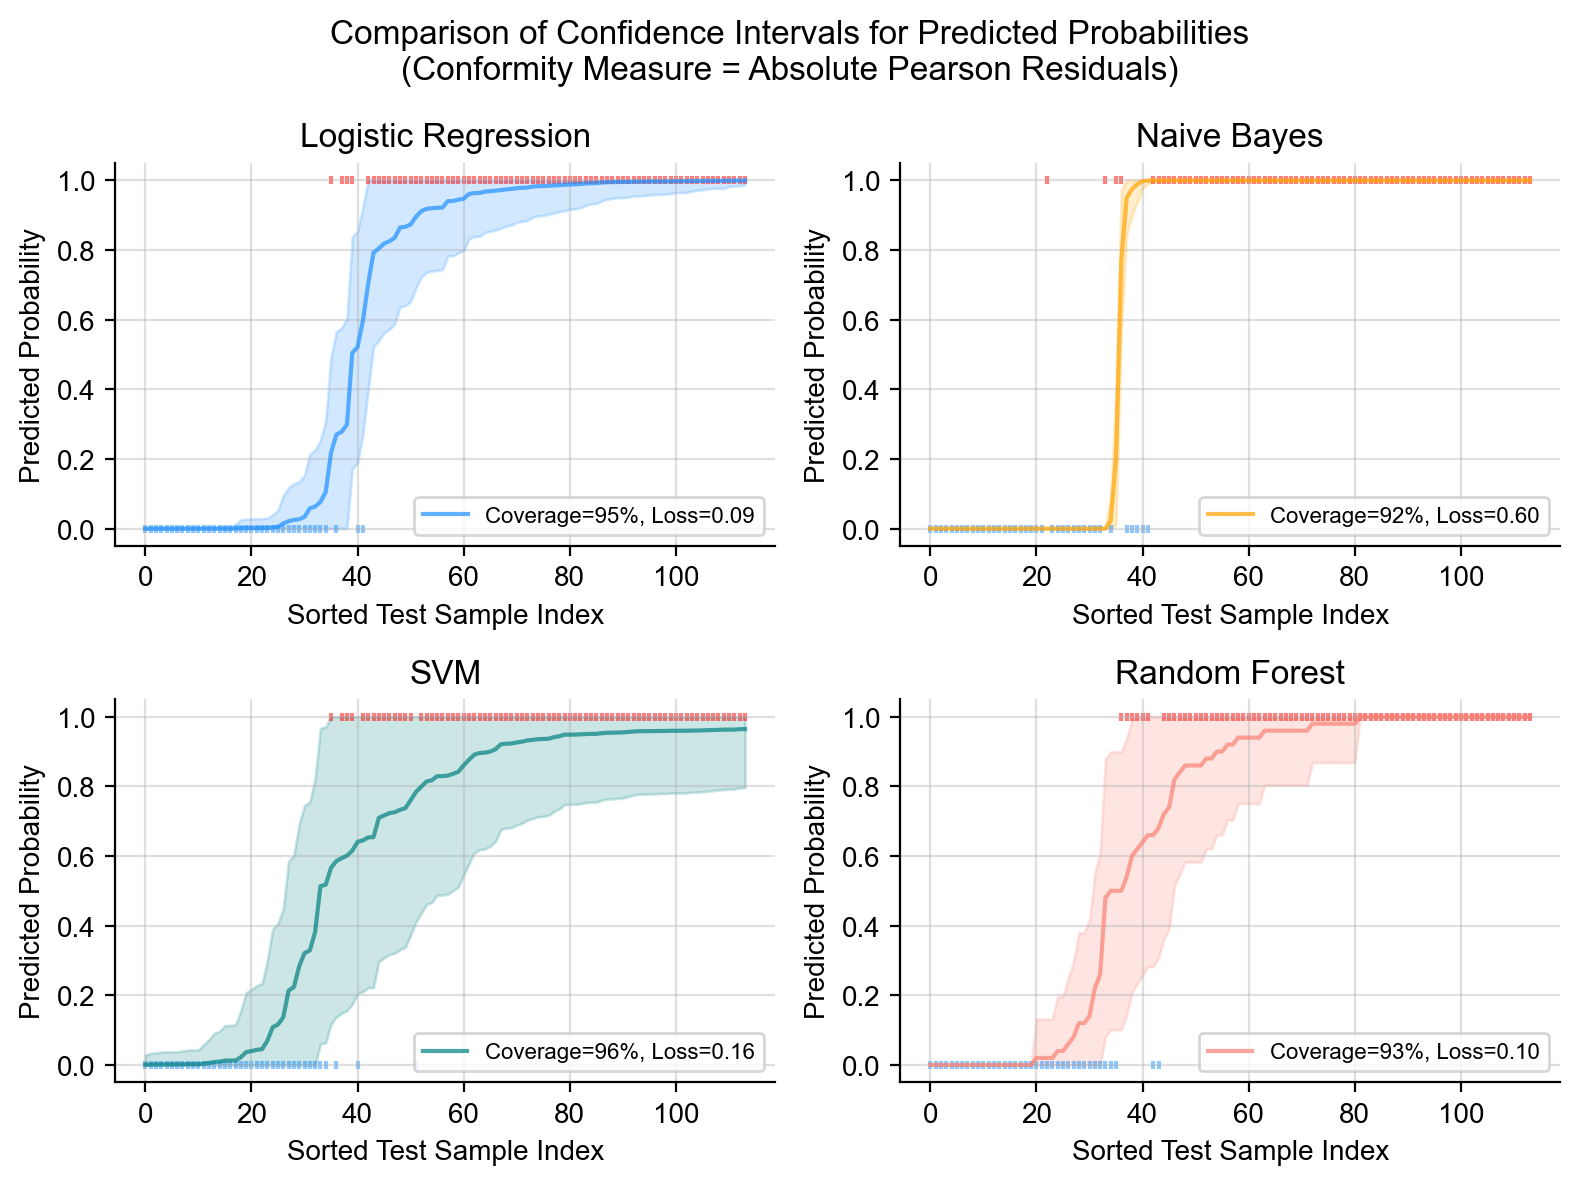

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

# Set font to Arial
plt.rcParams['font.family'] = 'Arial'

# Function to compute squared Pearson residuals
def compute_pearson_residuals(y_true, y_pred_proba):
    y_pred_proba = np.clip(y_pred_proba, 1e-10, 1 - 1e-10)
    return (y_true - y_pred_proba) / np.sqrt(y_pred_proba * (1 - y_pred_proba))

# Function to compute confidence intervals
def compute_confidence_intervals(y_pred_proba, q_alpha):
    lower_bound = []
    upper_bound = []
    for prob in y_pred_proba:
        lb = max(0, prob - np.sqrt(q_alpha * prob * (1 - prob)))
        ub = min(1, prob + np.sqrt(q_alpha * prob * (1 - prob)))
        lower_bound.append(lb)
        upper_bound.append(ub)
    return np.array(lower_bound), np.array(upper_bound)

# Function to calculate coverage
def calculate_coverage(y_true, lower_bounds, upper_bounds):
    return np.mean((y_true >= lower_bounds) & (y_true <= upper_bounds))

# Load the Breast Cancer Dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Split data into train, calibration, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_cal, X_test, y_cal, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# List of classifiers to compare
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42)
}

# Colors for plots
colors = ["dodgerblue", "orange", "teal", "salmon"]

# Create a grid for subplots
n_classifiers = len(classifiers)
n_cols = 2
n_rows = (n_classifiers + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 6), dpi=200)
axes = axes.flatten()  # Flatten axes to iterate easily

# Determine the (1-alpha) quantile as the cutoff
alpha = 0.05
for ax, (name, clf), color in zip(axes, classifiers.items(), colors):
    # Train the classifier
    clf.fit(X_train, y_train)

    # Compute non-conformity scores for calibration set
    y_cal_pred_proba = clf.predict_proba(X_cal)[:, 1]
    r2_cal = compute_pearson_residuals(y_cal, y_cal_pred_proba)
    r2_cal_abs = abs(r2_cal)

    # Compute summary statistic
    chi_square = np.sum(r2_cal ** 2)

    q_alpha = np.quantile(r2_cal_abs, 1 - alpha)

    # Apply the method to the test set
    y_test_pred_proba = clf.predict_proba(X_test)[:, 1]
    lower_bounds, upper_bounds = compute_confidence_intervals(y_test_pred_proba, q_alpha)

    # Sort predictions and corresponding intervals for visualization
    sorted_indices = np.argsort(y_test_pred_proba)
    y_test_pred_proba_sorted = y_test_pred_proba[sorted_indices]
    lower_bounds_sorted = lower_bounds[sorted_indices]
    upper_bounds_sorted = upper_bounds[sorted_indices]
    y_test_sorted = y_test[sorted_indices]

    # Calculate coverage
    coverage = calculate_coverage(y_test, lower_bounds, upper_bounds)

    # Compute log loss
    log_loss_value = log_loss(y_test, y_test_pred_proba)

    # Plot predicted probabilities and intervals
    ax.plot(
        y_test_pred_proba_sorted,
        label=(
            f"Coverage={coverage:.0%}, "
            f"Loss={log_loss_value:.2f}"
            # f"χ2={chi_square:.2f})"
        ),
        color=color, alpha=0.7
    )
    ax.fill_between(
        range(len(y_test_pred_proba_sorted)),
        lower_bounds_sorted,
        upper_bounds_sorted,
        color=color,
        alpha=0.2
    )

    # Plot data points with true labels
    for label in np.unique(y_test_sorted):
        indices = np.where(y_test_sorted == label)[0]
        ax.scatter(
            indices, 
            y_test_sorted[indices], 
            marker='|',
            c="red" if label == 1 else "dodgerblue", 
            s=10, 
            alpha=0.5, 
        )

    # Formatting
    ax.set_title(f"{name}")
    ax.set_xlabel("Sorted Test Sample Index")
    ax.set_ylabel("Predicted Probability")
    ax.legend(fontsize=8)
    ax.grid(alpha=0.4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Remove unused subplots if any
for ax in axes[n_classifiers:]:
    fig.delaxes(ax)

plt.suptitle("Comparison of Confidence Intervals for Predicted Probabilities\n(Conformity Measure = Absolute Pearson Residuals)")
plt.tight_layout()
plt.show()